# OMNI data prep and manipulation
Brian Larsen, LANL, balarsen@lanl.gov

Make the OMNI data into vectors for use in this work


In [1]:
%load_ext version_information

In [2]:
import datetime
from pprint import pprint
from itertools import tee

import spacepy.plot as spp
import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import omni
from spacepy import time as spt
from spacepy import plot as spp
spp.revert_style()
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import tqdm
from scipy import stats
import matplotlib
from sklearn.neighbors import KDTree
import tqdm 
from spacepy import omni as omni
from spacepy import toolbox as tb
from spacepy import time as spt
from spacepy import datamodel as dm
import scipy

import verify

%version_information numpy, matplotlib, version_information, verify, scipy, sklearn, seaborn, spacepy

/Users/balarsen/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Software,Version
Python,3.7.0 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.0.1
OS,Darwin 17.7.0 x86_64 i386 64bit
numpy,1.15.2
matplotlib,3.0.0
version_information,1.0.3
verify,The 'verify' distribution was not found and is required by the application
scipy,1.1.0
sklearn,0.20.0
seaborn,0.9.0


## OMNI needed on 8 hour cadence
* Times are given as bin start times

In [3]:
# tb.update(omni=True, omni2=True)

In [4]:
# need ticktocks over the time interval to her 8 hour averaged OMNI
times = pd.DatetimeIndex(start='2001-01-01', end='2020-01-01', freq='8H')
tt_times = spt.Ticktock(times.to_pydatetime())
pprint(tt_times[0:4])

Ticktock( [datetime.datetime(2001, 1, 1, 0, 0) datetime.datetime(2001, 1, 1, 8, 0)
 datetime.datetime(2001, 1, 1, 16, 0) datetime.datetime(2001, 1, 2, 0, 0)], dtype=UTC)


/Users/balarsen/.local/lib/python3.7/site-packages/spacepy/time.py:228: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(dtype, collections.Callable):


In [5]:
# get the omni data
om = omni.get_omni(tt_times)
om.keys()

dict_keys(['ByIMF', 'Bz1', 'Bz2', 'Bz3', 'Bz4', 'Bz5', 'Bz6', 'BzIMF', 'DOY', 'Dst', 'G', 'Kp', 'Pdyn', 'RDT', 'W', 'akp3', 'dens', 'velo', 'ticks', 'UTC', 'Hr', 'Year', 'Qbits'])

In [6]:
# build a pandas dataframe of the Omnni data
keys = ['BzIMF', 'Dst', 'Kp', 'Pdyn', 'akp3', 'dens', 'velo', ] # 'ticks']

om_df = pd.DataFrame(data=om[keys])
om_df.index = pd.DatetimeIndex(om['ticks'].UTC)
om_df.head()

,BzIMF,Dst,Kp,Pdyn,akp3,dens,velo
2001-01-01 00:00:00,-0.7,-6.0,0.0,0.88,0.11,5.8,293.0
2001-01-01 08:00:00,-1.7,-2.0,1.0,1.55,0.50,11.1,285.0
2001-01-01 16:00:00,0.9,9.0,0.3,1.43,0.55,10.7,274.0
2001-01-02 00:00:00,1.3,-3.0,1.3,2.07,0.73,13.9,285.0
2001-01-02 08:00:00,0.9,11.0,0.0,1.53,0.42,10.8,272.0


In [7]:
om_df.dropna(inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119e2a0f0>,
      dtype=object)

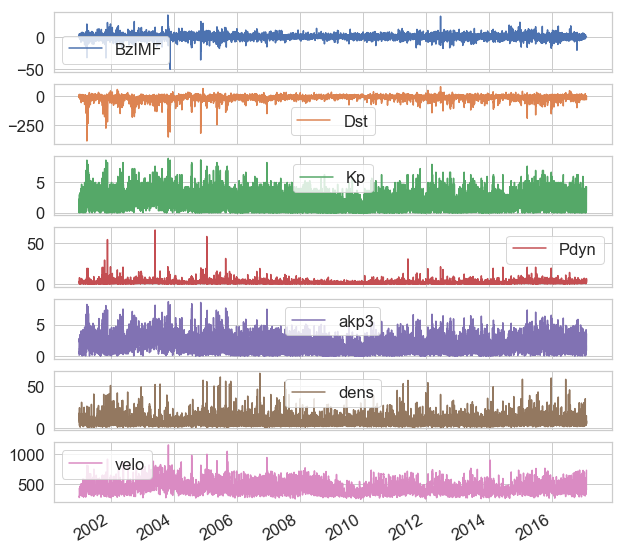

In [8]:
om_df.plot(figsize=(10,10), subplots=True)

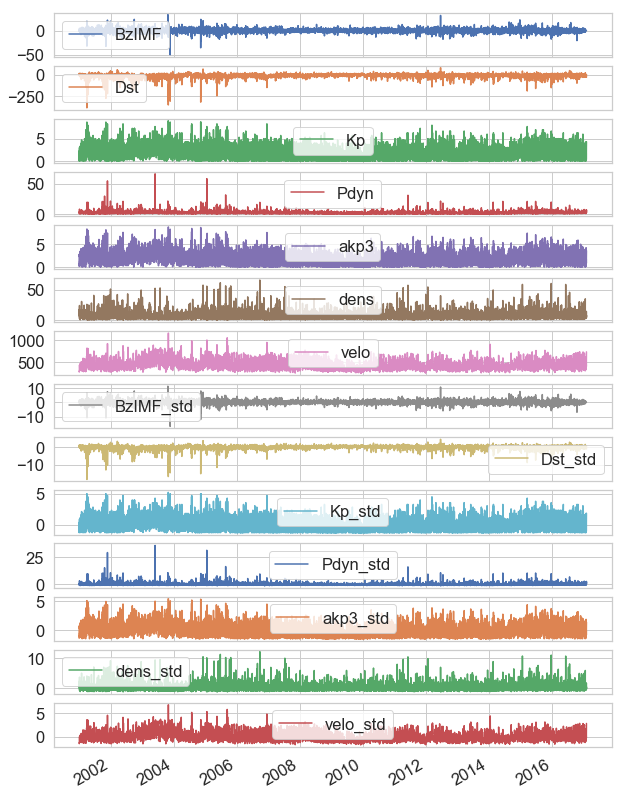

In [9]:
# standardide the variables
for k in om_df:
    if 'std' in k:
        continue
    om_df[k+'_std_mean'] = om_df[k].mean()
    om_df[k+'_std_std'] = om_df[k].std()
    om_df[k+'_std'] = (om_df[k]-om_df[k+'_std_mean'])/om_df[k+'_std_std']
    
columns = [v for v in om_df.columns if '_std_' not in v]

om_df[columns].plot(figsize=(10,15), subplots=True);

## Are there any gaps in the data?


In [10]:
om_df[columns].isna().sum()

BzIMF        0
Dst          0
Kp           0
Pdyn         0
akp3         0
dens         0
velo         0
BzIMF_std    0
Dst_std      0
Kp_std       0
Pdyn_std     0
akp3_std     0
dens_std     0
velo_std     0
dtype: int64

# Build the data into vectors 7 days + 1 measurement long
1. Get the start and end times of all the time periods
1. grab all the data in each of those, place into vector
1. increment start by 1 data point and repeat

## Build arrays of all the start/stop times needed to grab the data for vectors

In [11]:
p1 = pd.DatetimeIndex(start=om_df.index[0], end=om_df.index[-1], freq=datetime.timedelta(days=7, hours=8))
p1[0:5]

DatetimeIndex(['2001-01-01 00:00:00', '2001-01-08 08:00:00',
               '2001-01-15 16:00:00', '2001-01-23 00:00:00',
               '2001-01-30 08:00:00'],
              dtype='datetime64[ns]', freq='176H')

In [ ]:
(p1[1]-p1[0]).total_seconds()/3600/8

22.0

In [ ]:
periods = []
for ii in range(int((p1[1]-p1[0]).total_seconds()/3600/8)):
    periods.append(p1+pd.DateOffset(hours=8*ii))

In [ ]:
len(periods)

22

In [ ]:
# the last periods[-1][0] should be the point before periods[0][1]
for p in periods:
    print(p[:4])
assert (periods[0][1] - periods[-1][0]).total_seconds() == 3600*8

DatetimeIndex(['2001-01-01 00:00:00', '2001-01-08 08:00:00',
               '2001-01-15 16:00:00', '2001-01-23 00:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-01-01 08:00:00', '2001-01-08 16:00:00',
               '2001-01-16 00:00:00', '2001-01-23 08:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-01-01 16:00:00', '2001-01-09 00:00:00',
               '2001-01-16 08:00:00', '2001-01-23 16:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-01-02 00:00:00', '2001-01-09 08:00:00',
               '2001-01-16 16:00:00', '2001-01-24 00:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-01-02 08:00:00', '2001-01-09 16:00:00',
               '2001-01-17 00:00:00', '2001-01-24 08:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-01-02 16:00:00', '2001-01-10 00:00:00',
               '2001-01-17 08:00:00', '2001-01-24 16:00:00'],
       

## Using the start/stop times grab all the data and make vectors

In [ ]:
# make a dataframe with the data for the first week, 
# the index is the measurement time, the columns is the hours before the measurement
vector_OMNI_dict = {}
for c in columns:
    vector_OMNI_dict[c] = pd.DataFrame({v:om_df[c].iloc[ii] for ii, v in enumerate(range(-176, 1, 8))}, 
                                   index=[periods[0][1]])
print(c)
vector_OMNI_dict[c]

velo_std


,-176,-168,-160,-152,-144,-136,-128,-120,-112,-104,...,-72,-64,-56,-48,-40,-32,-24,-16,-8,0
2001-01-08 08:00:00,-1.322973,-1.398215,-1.501671,-1.398215,-1.520482,-1.379404,-0.956172,-0.730448,-0.683422,-0.485914,...,-0.391862,-0.137923,-0.213164,-0.354242,-0.55175,-0.692827,-0.758664,-0.617586,-0.598776,-0.495319


In [ ]:
# This can be done much smarter with .loc[]
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

vector_OMNI_dict = {}

for ic, c in enumerate(tqdm.tqdm_notebook(columns)):
    vector_OMNI_dict[c] = []
    for p in tqdm.tqdm_notebook(periods):
        TMP_DF = pd.DataFrame({v:om_df[c].iloc[ii] for ii, v in enumerate(range(-176, 1, 8))}, index=[0])
        for t1, t2 in pairwise(p):
            tmpv = om_df[c].loc[t1:t2].values
            if len(tmpv) != 23:
                continue
            TMP_DF.loc[t2] = tmpv
        vector_OMNI_dict[c].append(TMP_DF)


# vectors_Log_Flux = pd.concat(vectors_Log_Flux)
# vectors_Log_Flux.drop(0, inplace=True) # drop the 0 row at the top
# vectors_Log_Flux_std = pd.concat(vectors_Log_Flux_std)
# vectors_Log_Flux_std.drop(0, inplace=True) # drop the 0 row at the top


In [ ]:
for c in tqdm.tqdm_notebook(vector_OMNI_dict):
    vector_OMNI_dict[c] = pd.concat(vector_OMNI_dict[c])
    vector_OMNI_dict[c].drop(0, inplace=True)
    vector_OMNI_dict[c].index = pd.DatetimeIndex(vector_OMNI_dict[c].index)
    vector_OMNI_dict[c].sort_index(inplace=True)

In [ ]:
vector_OMNI_dict.keys()

In [ ]:
vector_OMNI_dict['BzIMF'].describe()

In [ ]:
vector_OMNI_dict['BzIMF'].head()

In [ ]:
vector_OMNI_dict['BzIMF'][[-16,-8,0]].loc['2002-01'].plot(figsize=(10,6))


In [ ]:
vector_OMNI_dict['Kp'][[-16,-8,0]].loc['2002-01'].plot(figsize=(10,6))


# Store the data to disk as an HDF5
read in best with pandas, likely needs pytables

In [ ]:
store = pd.HDFStore('../Data/OMNI_Vectors.h5', mode='w', complevel=9)

In [ ]:
for c in tqdm.tqdm_notebook(vector_OMNI_dict):
    store[c] = vector_OMNI_dict[c]
store.close()

# Read the file back and compare

In [ ]:
a = pd.read_hdf('../Data/OMNI_Vectors.h5', 'BzIMF')

In [ ]:
(vector_OMNI_dict['BzIMF'] - a).any()

# Demonstrate how to get the vectors out

In [ ]:
del a

## The vector at a time


In [ ]:
vector_OMNI_dict['BzIMF'].loc['2001-03-06T08:00:00'].values